In [81]:
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision import transforms
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os

## **Loading Dataset**

In [ ]:
train_dataset = MNIST(root='./data',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)

In [19]:
test_dataset = MNIST(root='./data',
                     train=False,
                     transform=transforms.ToTensor())

## **Separating the Dataset**

In [20]:
train_size = int(len(train_dataset)*0.9)

In [21]:
val_size = int(len(train_dataset)*0.1)

In [23]:
torch.manual_seed(27)

In [24]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_size, val_size])

## **Creating the Dataloader Object**

In [27]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2)

In [28]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=2)

In [29]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2)

## **Analysis of Class Distribution**

### **Train**

In [31]:
train_counter = Counter()

In [32]:
for _, labels in train_dataloader:
    train_counter.update(labels.tolist())

In [33]:
print("Train class distribution: ", sorted(train_counter.items()))

Train class distribution:  [(0, 5370), (1, 6066), (2, 5366), (3, 5520), (4, 5277), (5, 4857), (6, 5318), (7, 5624), (8, 5245), (9, 5357)]


### **Test**

In [34]:
test_counter = Counter()

In [35]:
for _, labels in test_dataloader:
    test_counter.update(labels.tolist())

In [36]:
print("Test class distribution: ", sorted(test_counter.items()))

Test class distribution:  [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### **Val**

In [37]:
val_counter = Counter()

In [38]:
for _, labels in val_dataloader:
    val_counter.update(labels.tolist())

In [39]:
print("Test class distribution: ", sorted(test_counter.items()))

Test class distribution:  [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


## **Viewing some Data**

In [55]:
for images, _ in train_dataloader:
    break

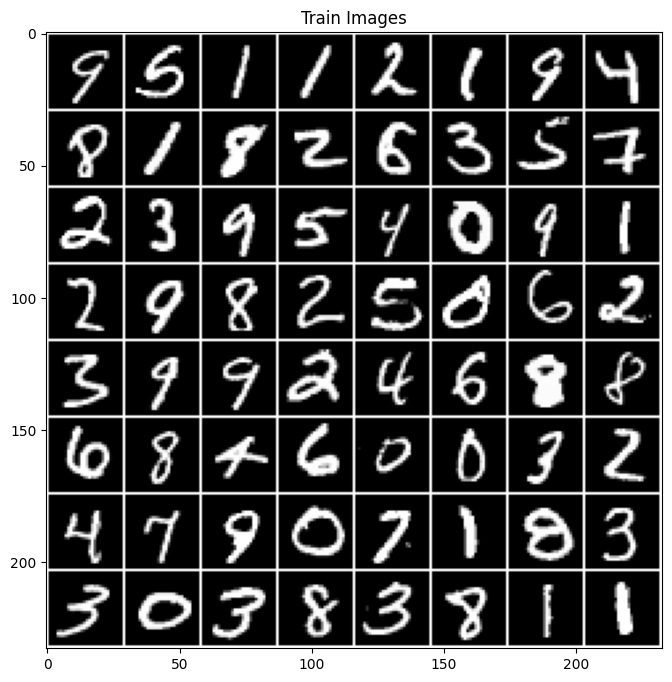

In [56]:
plt.figure(figsize=(8, 8))
plt.title("Train Images")
plt.imshow(np.transpose(make_grid(images[:64], 
                                  padding=1,
                                  pad_value=1.0,
                                  normalize=True), 
                                  (1, 2, 0)))

## **MLP**

In [67]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 16),
            torch.nn.ReLU(),

            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),

            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),

            torch.nn.Linear(16, output_size),
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.layers(x)

In [83]:
torch.manual_seed(27)

In [84]:
height, width = images.shape[2:]

In [85]:
input_size = height * width
output_size = 10

In [103]:
model = MLP(input_size=input_size, output_size=output_size).to('cuda')

In [104]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

## **Training**

In [105]:
def accuracy(model, dataloader):
    model = model.eval()

    accuracy = 0.0
    total = 0

    for x,y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')
        
        with torch.inference_mode():
            z = model(x)
        
        labels = torch.argmax(z,dim=1)
        labels = labels.view(y.shape).to(y.dtype)

        results = labels == y
        accuracy += torch.sum(results)
        total += len(results)

    return (accuracy/total).item()

In [106]:
epochs = 10

In [107]:
if not os.path.exists('logs'):
    os.mkdir('logs')

log_writer = SummaryWriter(log_dir='logs/PerceptronMNIST')

In [108]:
for epoch in range(epochs):
    model = model.train()

    for index, (x, y) in enumerate(train_dataloader):
        x = x.to('cuda')
        y = y.to('cuda')

        z = model(x)
        loss = F.cross_entropy(z, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % 200 == 0:
            print(f'Epoch: {epoch+1:03d}/{epochs:03d} - Batch: {index+1:03d}/{len(train_dataloader):03d} - Loss: {loss:.3f}')
    
    print(f'Train accuracy: {accuracy(model, train_dataloader)*100: .2f}% - Val accuracy: {accuracy(model, test_dataloader)*100: .2f}%')
    torch.save(model.state_dict(), 'weights.pth')
    log_writer.add_scalar('Loss/epoch', loss, epoch)

Epoch: 001/010 - Batch: 001/844 - Loss: 2.304
Epoch: 001/010 - Batch: 201/844 - Loss: 0.619
Epoch: 001/010 - Batch: 401/844 - Loss: 0.329
Epoch: 001/010 - Batch: 601/844 - Loss: 0.132
Epoch: 001/010 - Batch: 801/844 - Loss: 0.520
Train accuracy:  93.13% - Val accuracy:  93.01%
Epoch: 002/010 - Batch: 001/844 - Loss: 0.237
Epoch: 002/010 - Batch: 201/844 - Loss: 0.458
Epoch: 002/010 - Batch: 401/844 - Loss: 0.153
Epoch: 002/010 - Batch: 601/844 - Loss: 0.207
Epoch: 002/010 - Batch: 801/844 - Loss: 0.148
Train accuracy:  94.03% - Val accuracy:  93.63%
Epoch: 003/010 - Batch: 001/844 - Loss: 0.332
Epoch: 003/010 - Batch: 201/844 - Loss: 0.302
Epoch: 003/010 - Batch: 401/844 - Loss: 0.258
Epoch: 003/010 - Batch: 601/844 - Loss: 0.395
Epoch: 003/010 - Batch: 801/844 - Loss: 0.121
Train accuracy:  92.27% - Val accuracy:  91.34%
Epoch: 004/010 - Batch: 001/844 - Loss: 0.217
Epoch: 004/010 - Batch: 201/844 - Loss: 0.180
Epoch: 004/010 - Batch: 401/844 - Loss: 0.239
Epoch: 004/010 - Batch: 601/

## **Evaluating the Results**

In [110]:
weights = torch.load('weights.pth', map_location=torch.device('cuda'))

C:\Users\ryann\AppData\Local\Temp\ipykernel_11124\2784596645.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('weights.pth', map_location=torch.devic

In [111]:
model.load_state_dict(weights)

<All keys matched successfully>

In [112]:
print(f"Test accuracy: {accuracy(model, test_dataloader)*100:.2f}%")

Test accuracy: 94.56%
